# Classification of U.S. Air Force Flight Simulator Data Using Machine Learning and Neural Networks
# Brian Mann

In [1]:
# imported libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import shutil
from sklearn import metrics
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Reading and Cleaning TSV Data

In [2]:
# this function takes in a path to one of the tsv files and returns a 
# df with altered column names, minus the index column
def clean_tsv(path):
    df = pd.read_csv(path, delimiter='\t')
    df.columns = ['index', 'time', 'xpos', 'ypos', 'zpos', 'vx', 'vy', 'vz', 'heading', 'pitch', 'roll']
    df = df.drop(columns='index')
    return df

In [3]:
# this function takes in a dataframe containing flight sim data
# it returns a list of stats including the total duration, distance range, and other values 
def extract_tsv_stats(df):
    # initialize the stats dictionary
    stats = dict()
    # calculate the flight duration as the maximum oftime
    stats['duration'] = df['time'].max()
    # add the ranges for each of the numeric columns for position, speed, and angle
    for col in df.columns[1:]:
        stats[col + '_range'] = df[col].max() - df[col].min()
    # 'highspeed' indicates if a speed is above the maximum speed of the T-6 aircraft (~170 m/s)
    stats['highspeed'] = 0
    for col in ['vx', 'vy', 'vz']:
        if df[col].max() > 170 or abs(df[col].min()) > 170:
            stats['highspeed'] = 1
            break
    # 'teleporting' is set to 1 if the aircraft jumps 500m in some direction within 0.2s
    stats['teleporting'] = 0
    # get the first values for the position of the aircraft
    cx, cy, cz = df.loc[0, ['xpos']].values[0], df.loc[0, ['ypos']].values[0], df.loc[0, ['zpos']].values[0]
    # create a running tally of how many times the aircraft is stationary in adjacent rows
    totalsame = 0
    for i, row in df.iterrows():
        # if the aircraft did not change positions, increase the 'totalsame' variable by 1
        if row['xpos'] == cx and row['ypos'] == cy:
            totalsame += 1
        # if the aircraft jumped 500m, switch the teleporting indicator to 1
        if (abs(row['xpos'] - cx) > 500) or (abs(row['ypos'] - cy) > 500) or (abs(row['zpos'] - cz) > 500):
            stats['teleporting'] = 1
        cx, cy, cz = row['xpos'], row['ypos'], row['zpos']
    # calculate the overall rate that the aircraft was stationary in the XY plane
    stats['pct_same'] = totalsame / len(df)
    # return the stats dictionary
    return stats

In [4]:
# iterate over each file in the 'bad' simulations, calculating the stats, then adding 
# the stats dictionary to a list of rows that will be formed into a DataFrame
path = '/Users/alexmann/Documents/Datas/FlightData/tsv_bad/'
rows = list()
for file in os.listdir(path):
    if file.endswith('.tsv'):
        stats = extract_tsv_stats(clean_tsv(path + file))
        stats['id'] = file[:11]
        stats['good'] = 0
        rows.append(stats)

In [5]:
len(rows)

946

In [6]:
# iterate over each file in the 'good' simulations, calculating the stats, then adding 
# the stats dictionary to a list of rows that will be formed into a DataFrame
path = '/Users/alexmann/Documents/Datas/FlightData/tsv_good/'
for i, file in enumerate(os.listdir(path)):
    # make periodic checks that the proper data is being added
    if i%500 == 0:
        print(f'Over {i} checked. So far so good.')
    if file.endswith('.tsv'):
        stats = extract_tsv_stats(clean_tsv(path + file))
        stats['id'] = file[:11]
        stats['good'] = 1
        rows.append(stats)

Over 0 checked. So far so good.
Over 500 checked. So far so good.
Over 1000 checked. So far so good.
Over 1500 checked. So far so good.
Over 2000 checked. So far so good.
Over 2500 checked. So far so good.
Over 3000 checked. So far so good.
Over 3500 checked. So far so good.
Over 4000 checked. So far so good.
Over 4500 checked. So far so good.
Over 5000 checked. So far so good.
Over 5500 checked. So far so good.


In [7]:
len(rows)

6664

In [8]:
# take the list of rows of stats and form it into a DataFrame
tsvdf = pd.DataFrame(rows)
tsvdf.head()

,duration,xpos_range,ypos_range,zpos_range,vx_range,vy_range,vz_range,heading_range,pitch_range,roll_range,highspeed,teleporting,pct_same,id,good
0,216.465,0.096933,0.000000,0.000000,3.191789e-02,5.559652e-02,0.089798,0.0000,1.000000e-07,7.500000e-08,0,0,0.999063,13000190003,0
1,298.932,0.000000,0.000000,0.000000,1.081031e-10,3.286827e-11,0.036765,0.0000,0.000000e+00,0.000000e+00,0,0,1.000000,13000643008,0
2,230.127,1.066376,0.554229,0.000000,1.117084e-03,5.720090e-04,0.000066,0.0001,1.254200e-02,3.956716e-02,0,0,0.986002,13001585005,0
3,3290.930,5.816159,9.200200,0.000005,5.302970e-04,8.445230e-04,0.000053,0.0034,8.074000e-03,3.960895e-02,0,0,0.991269,13001585015,0
4,796.328,4.813993,0.110858,0.000002,8.380389e-03,2.380986e-04,0.002685,0.2807,3.917300e-01,2.798681e-02,0,0,0.987131,12000184001,0


In [9]:
tsvdf.id.unique().size

6659

There appear to be a handful of duplicated rows, so let's deal with them. 

In [10]:
tsvdf[tsvdf.duplicated('id', keep=False)].sort_values('id')

,duration,xpos_range,ypos_range,zpos_range,vx_range,vy_range,vz_range,heading_range,pitch_range,roll_range,highspeed,teleporting,pct_same,id,good
15,380.415,0.678540,1.440996,0.000000e+00,5.326260e-04,0.001098,0.000080,0.044500,0.012390,0.027989,0,0,0.989424,12000353001,0
1043,380.415,0.678540,1.440996,0.000000e+00,5.326260e-04,0.001098,0.000080,0.044500,0.012390,0.027989,0,0,0.989424,12000353001,1
470,437.370,9790.340000,6790.410000,1.754699e+02,2.802446e+02,258.482900,25.124407,359.534653,45.673280,196.040750,0,0,0.000462,12000931004,0
3912,437.370,9790.340000,6790.410000,1.754699e+02,2.802446e+02,258.482900,25.124407,359.534653,45.673280,196.040750,0,0,0.000462,12000931004,1
853,584.129,0.000000,0.000000,0.000000e+00,5.005660e-08,0.000002,NaN,0.000000,0.000000,0.000000,0,0,1.000000,12001306001,0
6152,584.129,0.000000,0.000000,0.000000e+00,5.005660e-08,0.000002,NaN,0.000000,0.000000,0.000000,0,0,1.000000,12001306001,1
321,373.233,0.000000,2.217128,6.096000e-03,2.761330e-04,0.011962,0.025703,0.078200,0.777349,0.027998,0,0,0.989224,12002172001,0
3016,373.233,0.000000,2.217128,6.096000e-03,2.761330e-04,0.011962,0.025703,0.078200,0.777349,0.027998,0,0,0.989224,12002172001,1
208,302.640,2.617231,4.544681,1.000000e-06,4.457630e-04,0.000778,0.000241,0.046100,0.053448,0.027993,0,0,0.955274,12002622002,0
2340,302.640,2.617231,4.544681,1.000000e-06,4.457630e-04,0.000778,0.000241,0.046100,0.053448,0.027993,0,0,0.955274,12002622002,1


In [11]:
# get rid of all duplicated rows
tsvdf = tsvdf[~tsvdf.duplicated('id', keep=False)]

In [12]:
# check for NaN values
tsvdf[tsvdf.isna().any(axis=1)]

,duration,xpos_range,ypos_range,zpos_range,vx_range,vy_range,vz_range,heading_range,pitch_range,roll_range,highspeed,teleporting,pct_same,id,good
260,313.406,0.00,0.000,0.030480,NaN,NaN,0.108434,1.8041,2.145120e+00,1.762060,0,0,1.000000,12001887004,0
450,1509.089,0.00,0.000,0.024384,NaN,NaN,0.080899,1.5024,1.790287e+00,1.481508,0,0,1.000000,12001887005,0
454,482.301,0.00,0.000,0.009144,NaN,NaN,0.026142,0.4647,4.956450e-01,0.463145,0,0,1.000000,12000733001,0
644,480.540,0.00,0.000,0.012192,NaN,NaN,0.028909,0.9886,1.126051e+00,0.927414,0,0,1.000000,12001887001,0
680,236.121,0.00,0.000,0.030480,NaN,0.000001,0.147721,3.2941,4.188336e+00,3.511544,0,0,1.000000,12002299001,0
686,335.507,0.00,0.000,0.009144,NaN,NaN,0.025462,0.8781,9.772740e-01,0.841035,0,0,1.000000,12001315001,0
754,584.129,0.00,0.000,0.000000,1.665840e-08,0.000002,NaN,0.0000,0.000000e+00,0.000000,0,0,1.000000,12000838001,0
755,796.105,0.00,0.000,0.024384,NaN,NaN,0.076250,1.8113,2.181715e+00,1.795417,0,0,1.000000,12001887003,0
783,1751.468,0.00,0.000,0.009144,NaN,NaN,0.011368,0.6316,6.637530e-01,0.620640,0,0,1.000000,12000733002,0
784,236.121,0.00,0.000,0.000000,9.259400e-09,0.000004,NaN,0.0000,0.000000e+00,0.000000,0,0,1.000000,12002525001,0


There are around 15 rows with NaN values. We will simply fill them with zeroes. 

In [13]:
# fill the NaN values as zeroes
tsvdf = tsvdf.fillna(0.0)

## Exploratory Data Analysis on Extracted Features

In [14]:
# print out a list of statistics for each of the numerical features, 
# separated by 'good' and 'bad' flights
for col in tsvdf.columns[:13]:
    print(col)
    print(tsvdf.groupby('good')[col].describe().round(2))

duration
       count    mean     std     min     25%     50%     75%       max
good                                                                  
0      941.0  593.41  764.05  201.63  251.08  359.84  566.17   9016.49
1     5713.0  681.54  818.72  202.05  291.68  450.18  779.20  24096.94
xpos_range
       count      mean       std  min      25%       50%       75%       max
good                                                                        
0      941.0   2658.56  21577.89  0.0     0.38      0.78      1.84  441977.8
1     5713.0  21418.48  26444.47  0.0  6639.08  12427.46  26797.44  417213.0
ypos_range
       count      mean       std  min      25%       50%       75%       max
good                                                                        
0      941.0   3005.49  21065.87  0.0     0.44      1.00      2.77  313423.4
1     5713.0  23917.99  25342.21  0.0  8341.56  15348.02  31895.87  452439.1
zpos_range
       count    mean      std  min     25%     50%    75% 

In [15]:
# this function takes in a df, a list of columns, a category, and optional # of rows, columns and figure size
# it prints out a plot of histograms for each column, grouped by the categorical variable
def grouped_histograms(df, cols, grouper, nrows=1, ncols=2, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # iterate over each column, adding a histogram plot to the overall figure
    for idx, col in enumerate(cols):
        sns.histplot(df, x=col, hue=grouper, palette='Set1', ax=ax[idx])
        ax[idx].set_title(f'Histogram of {col} Grouped by {grouper}')
    # get rid of unused space
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

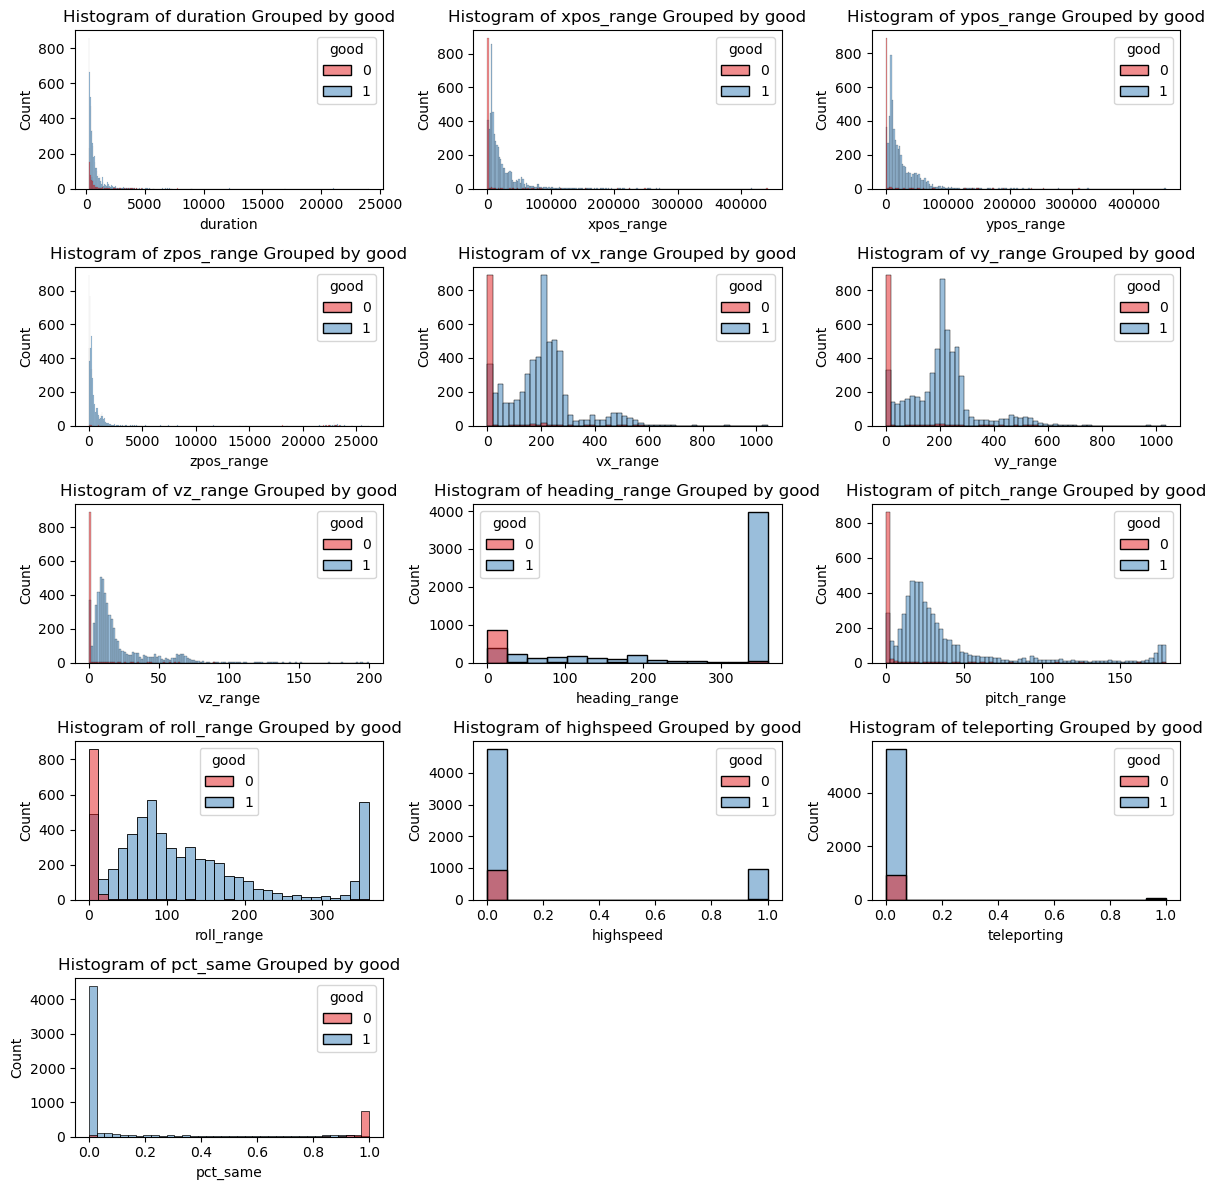

In [16]:
grouped_histograms(tsvdf, tsvdf.columns[:13], 'good', 5, 3)

In [17]:
# this function does the same thing as the grouped_histograms function, but instead of generating histograms
# it generates a boxplot colored by the given 'grouper'
def boxplots(df, cols, grouper, nrows=1, ncols=1, figsize=(12,12)):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    ax = ax.flatten()
    # generate each of the boxplots for the given columns    
    for idx, col in enumerate(cols):
        sns.boxplot(data=df, x=grouper, y=col, palette='Set1', ax=ax[idx])
        ax[idx].set_title(f'Boxplot of {col} Grouped by {grouper}')
    # delete unused plots
    for i in range(len(cols), len(ax)):
        fig.delaxes(ax[i])
    plt.tight_layout()
    plt.show()

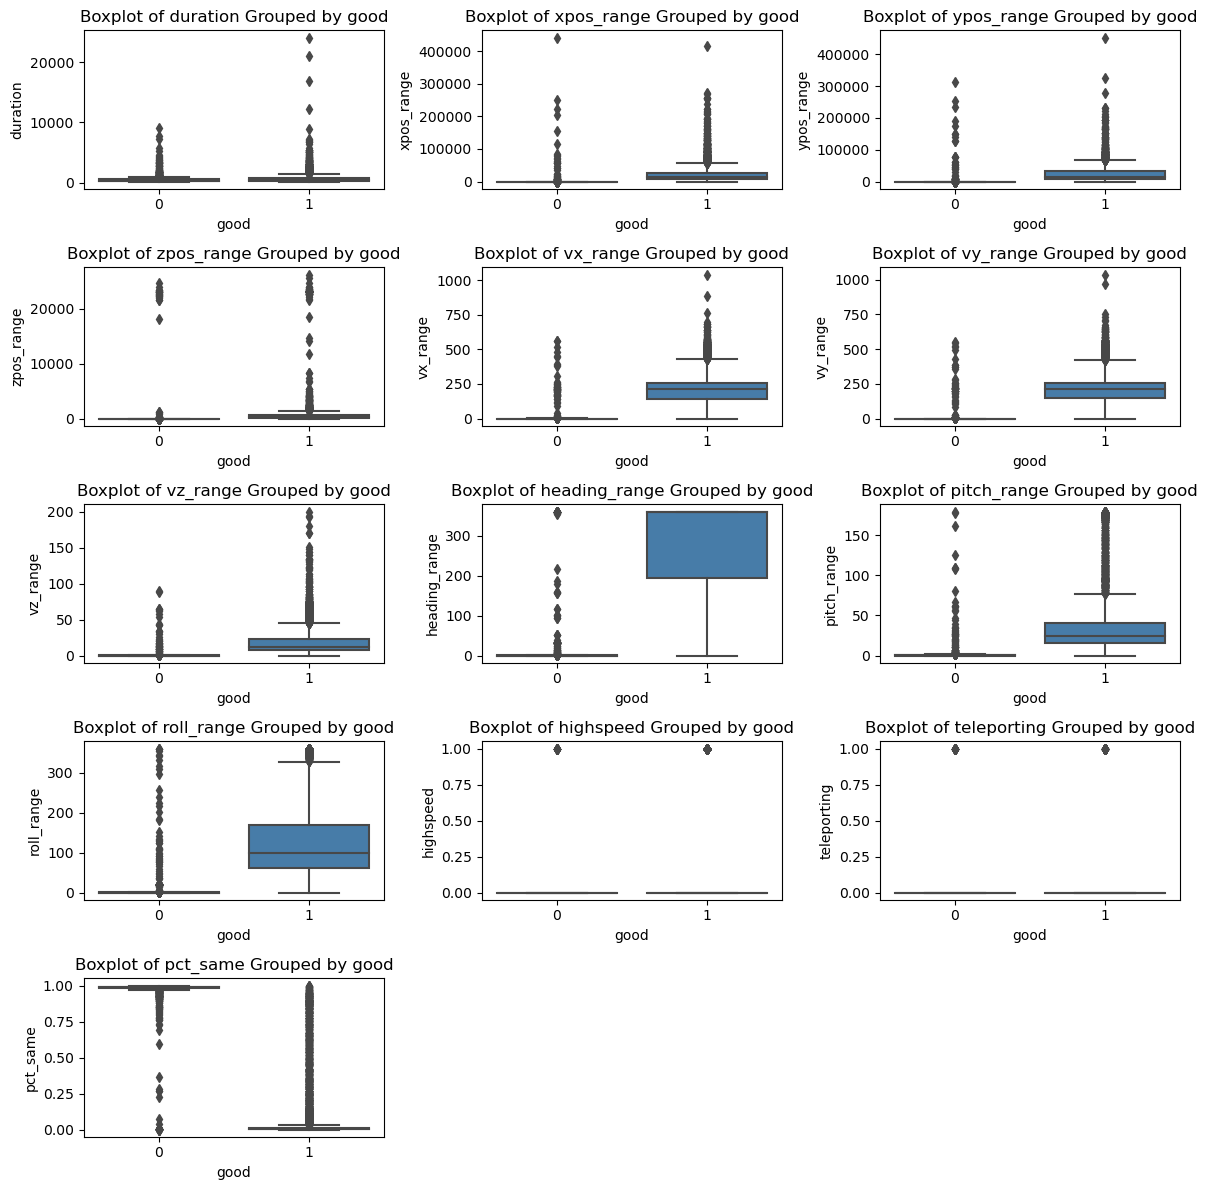

In [18]:
boxplots(tsvdf, tsvdf.columns[:13], 'good', 5, 3)

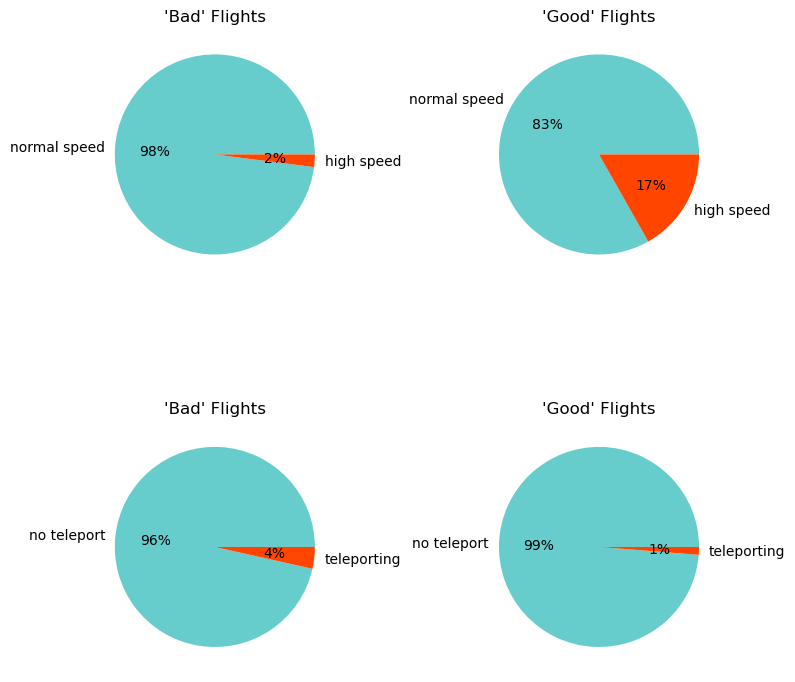

In [19]:
# get a list of percentages for 'highspeed' and 'teleporting' grouped by 'good' and 'bad' flights
hspeed = list((tsvdf.groupby('good').highspeed.value_counts(normalize=True)*100).values)
tport = list((tsvdf.groupby('good').teleporting.value_counts(normalize=True)*100).values)
# set labels
speed_labs = ['normal speed', 'high speed']
port_labs = ['no teleport', 'teleporting']
# initialize a 2x2 plot
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,8))
ax = ax.flatten()
# add each of the pairs of data points as pie charts to the plot
ax[0].pie(hspeed[:2], labels=speed_labs, autopct='%.0f%%', colors=['#66cccc', '#ff4500'])
ax[0].set_title('\'Bad\' Flights')
ax[1].pie(hspeed[2:4], labels=speed_labs, autopct='%.0f%%', colors=['#66cccc', '#ff4500'])
ax[1].set_title('\'Good\' Flights')
ax[2].pie(tport[:2], labels=port_labs, autopct='%.0f%%', colors=['#66cccc', '#ff4500'])
ax[2].set_title('\'Bad\' Flights')
ax[3].pie(tport[2:4], labels=port_labs, autopct='%.0f%%', colors=['#66cccc', '#ff4500'])
ax[3].set_title('\'Good\' Flights')
plt.tight_layout()
plt.show()

In [21]:
# get the correlation matrix for all features
corrs = tsvdf.corr()

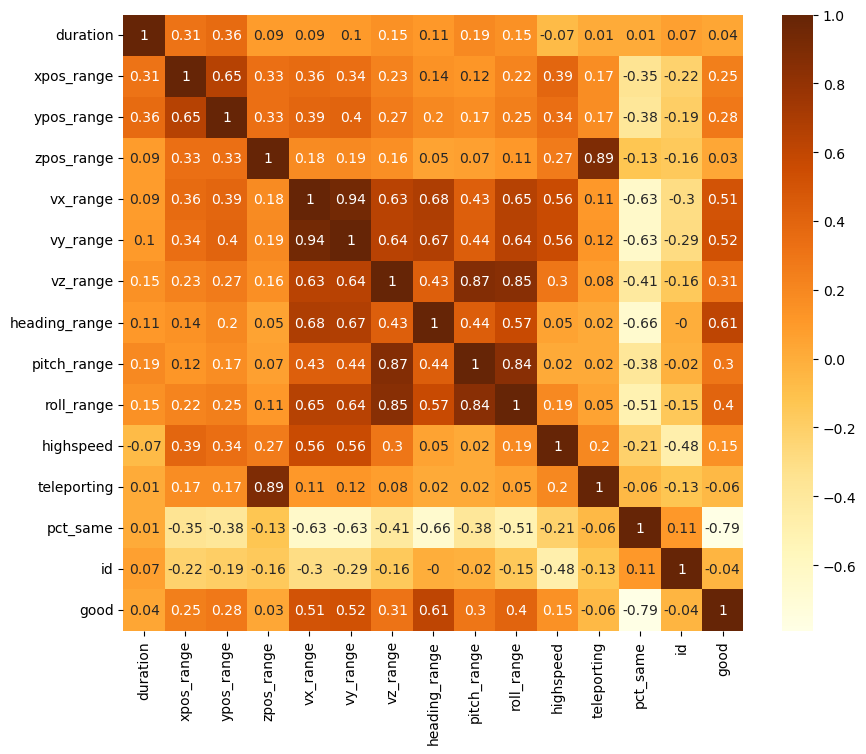

In [22]:
# plot the correlation as a heatplot
plt.figure(figsize=(10,8))
sns.heatmap(corrs.round(2), annot=True, cmap='YlOrBr')
plt.show()

## Machine Learning Modeling

In [23]:
# set the features as all columns aside from 'id' and the target
features = tsvdf.drop(columns=['id', 'good'])
# set the target as whether or not the data is 'good' or 'bad'
target = tsvdf['good']
# generate a set of training and testing data in the ratio 80/20, with the proportion of 
# target data being the same as in the overall dataset
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, stratify=target, random_state=5)

In [24]:
def logistic_regression_model():
    # initiate a standard scaler
    scaler = StandardScaler()
    # transform and fit the scaled training data
    xtrain_scaled = scaler.fit_transform(xtrain)
    xtest_scaled = scaler.transform(xtest)
    # generate the logistic regression model and fit it to the scaled training data
    lrm = LogisticRegression(max_iter=1000)
    lrm.fit(xtrain_scaled, ytrain)
    # create a prediction
    pred = lrm.predict(xtest_scaled)
    # print out the precision, recall and f-1 scores
    print(classification_report(ytest, pred))
    # print out a confusion matrix for the model's accuracy
    cm = confusion_matrix(ytest, pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

              precision    recall  f1-score   support

           0       0.88      0.94      0.91       188
           1       0.99      0.98      0.98      1143

    accuracy                           0.97      1331
   macro avg       0.94      0.96      0.95      1331
weighted avg       0.97      0.97      0.97      1331



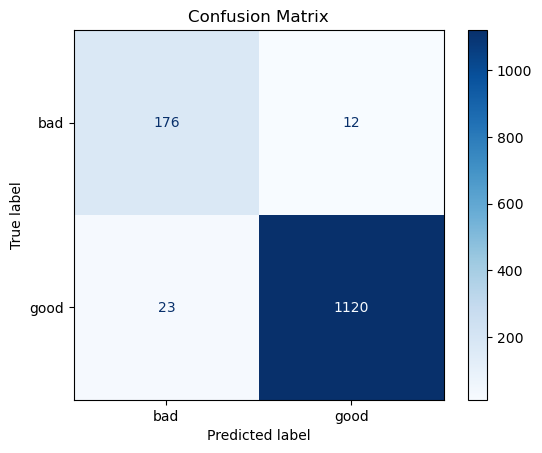

In [25]:
logistic_regression_model()

In [28]:
# this function fits a decision tree model to the training set, then compares the results to the 
# test set and prints them out
def decision_tree_model():
    # initiate a decision tree and fit it to the training data
    dtc = DecisionTreeClassifier(max_depth=2)
    dtc.fit(xtrain, ytrain)
    pred = dtc.predict(xtest)
    # print out the classification report
    print(classification_report(ytest, pred))
    # print out the confusion matrix for the model's accuracy
    cm = confusion_matrix(ytest, pred)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    # plot a visualization of the decision tree bifurcations
    plt.figure(figsize=(30,15))
    tree.plot_tree(dtc, filled=True, feature_names=list(features.columns), class_names=['bad', 'good'])
    plt.show()
    

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       188
           1       0.99      1.00      0.99      1143

    accuracy                           0.99      1331
   macro avg       0.98      0.96      0.97      1331
weighted avg       0.99      0.99      0.99      1331



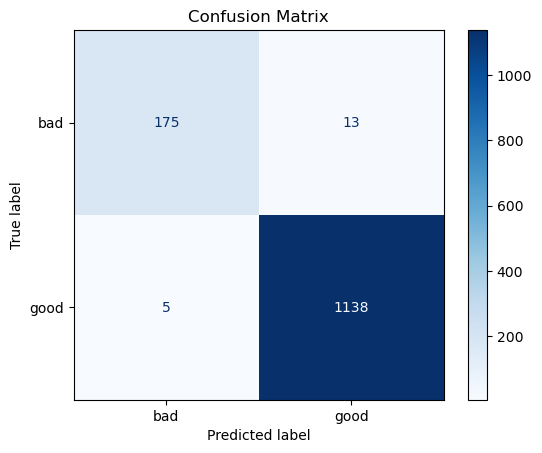

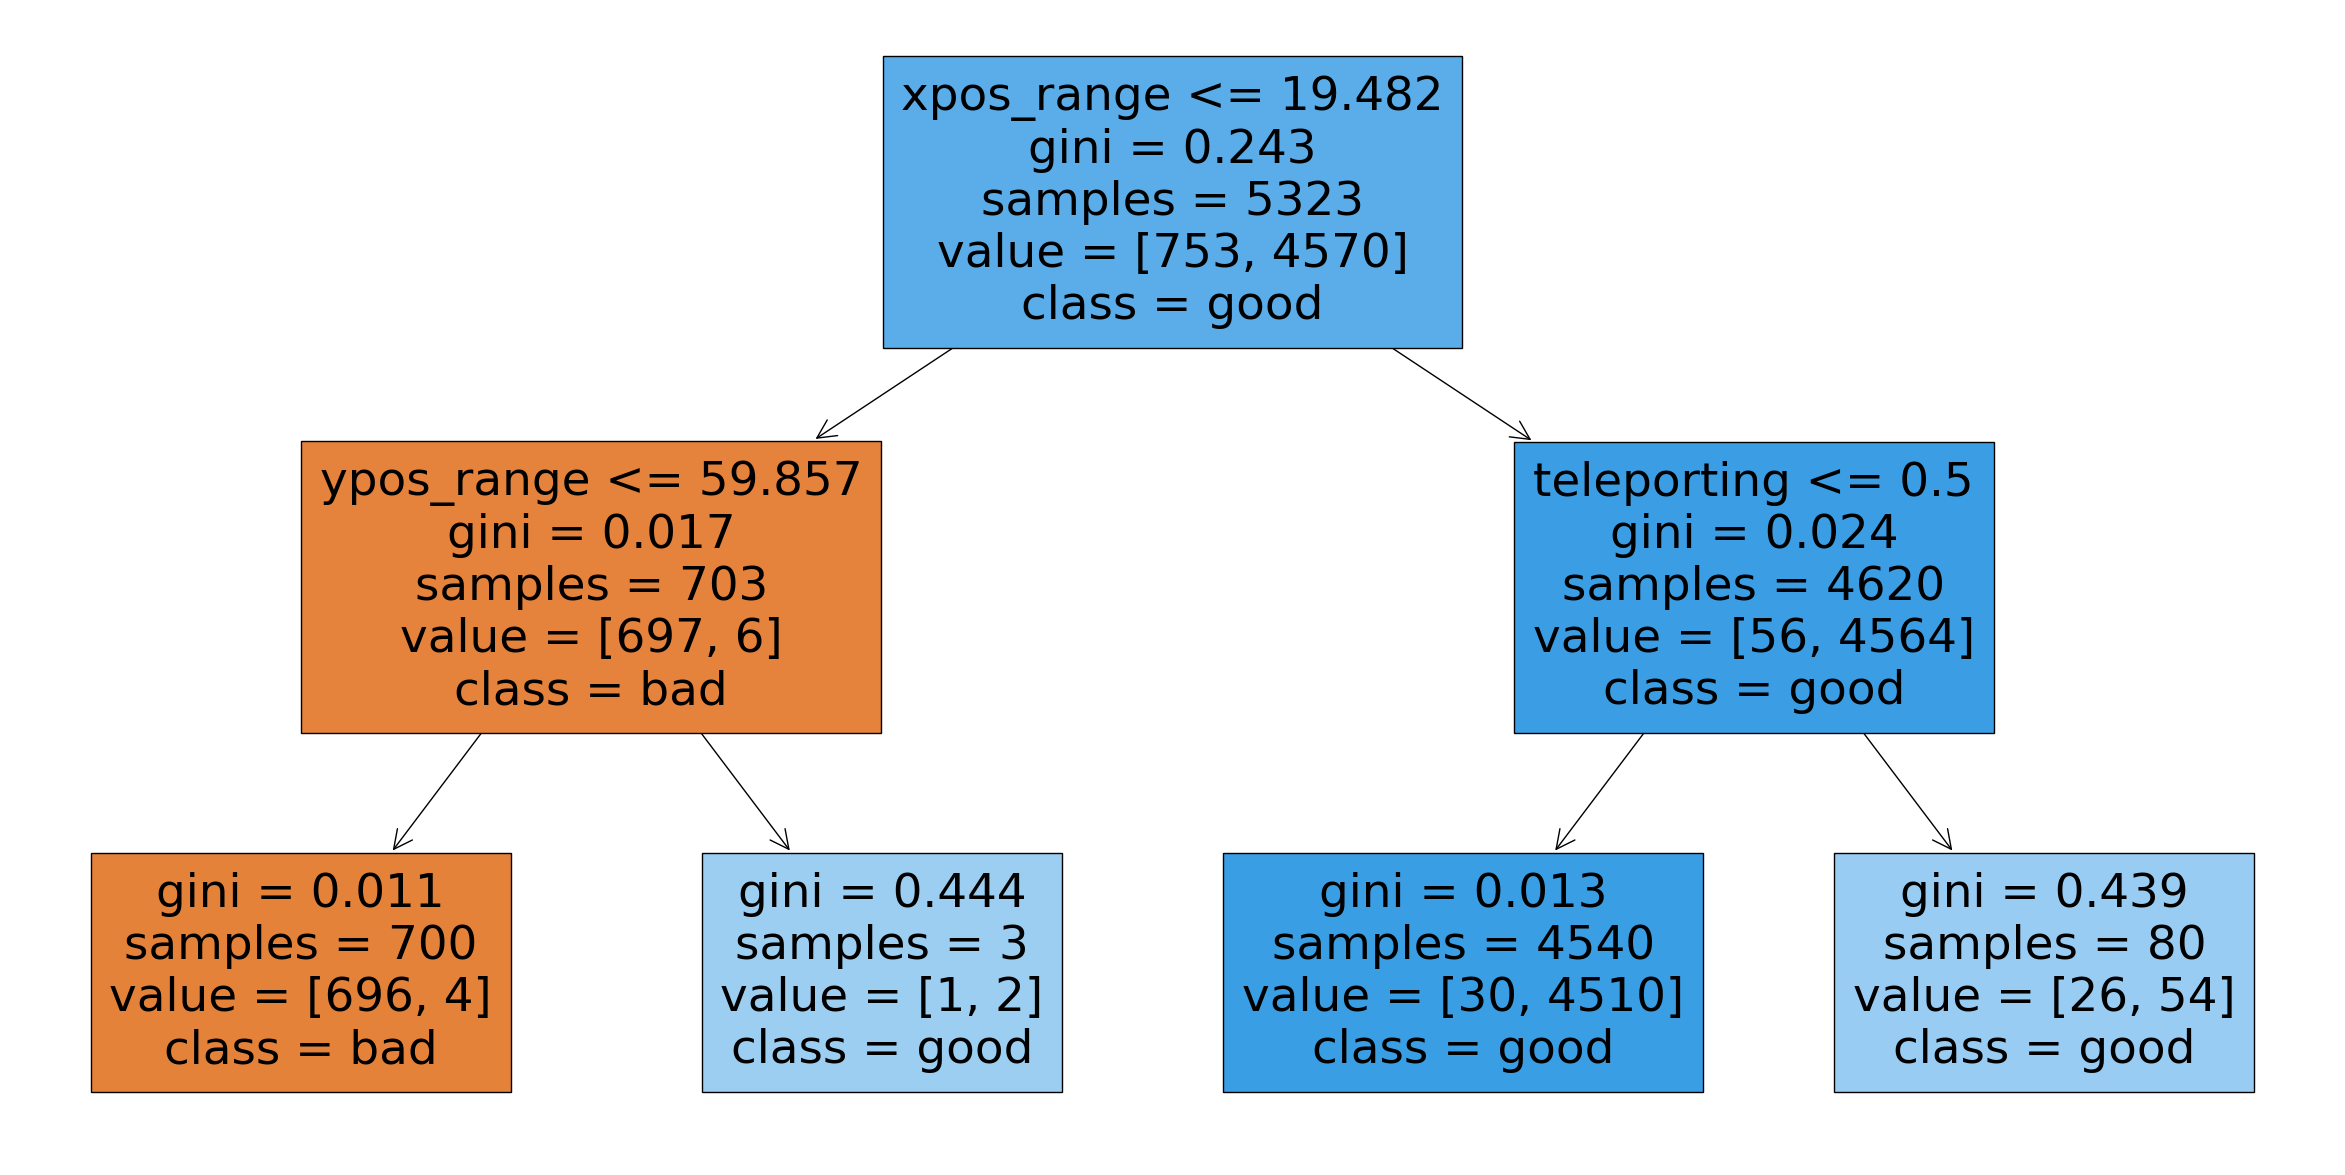

In [29]:
decision_tree_model()

## Reading and Cleaning PNG Data

In [ ]:
# use train_test_split to organize data into ids that we would like of 'good' and 'bad' flight data
features = tsvdf['id']
target = tsvdf['good']
# get a list of the ids for the same data used in the machine learning modeling phase
xtrain, xtest, ytrain, ytest = train_test_split(features, target, test_size=0.2, stratify=target, random_state=5)

In [ ]:
# this function takes in an ID number, category (good/bad), and ending (test/train)
def move_png(num, cat, ending):
    path = '/Users/alexmann/Documents/Datas/FlightData/png_'
    destination = path + ending + '/'
    file = num + '.min.xy.png'
    # if the category is 'good', set the destination to the corresponding folder
    if cat:
        path = path + 'good/' + file
        destination = destination + 'good/'
    # if the category is 'bad', set the destination to the corresponding folder
    else:
        path = path + 'bad/' + file
        destination = destination + 'bad/'
    # copy the file to the proper destination
    try:
        shutil.copy2(path, destination)
    except:
        print(f'file not found at {file}')
        return file
    return None

In [ ]:
# move the data to the proper training and testing folders
for idnum, goodbad in zip(xtrain, ytrain):
    move_png(idnum, goodbad, 'train')
for idnum, goodbad in zip(xtest, ytest):
    move_png(idnum, goodbad, 'test')

### ** Note: When testing the neural network, it was found that adjusting the training data to include even distributions of good/bad data caused the network to perform significantly better. In order to achieve this, images were taken out of the training folder until there were an even number of good/bad files (~750 images each). 

## Convolutional Neural Network

In [2]:
# this class creates a convolutional neural network with 3 convolutional layers, 2 fully connected layers,
# a max pooling layer, and a ReLU activation function that takes in images with 3 channels 
# that is designed for binary image classification tasks
class CNN(nn.Module):
    # initialize the network with convolutional, pooling, and fully connected layers
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        # adjust first FC layer to line up with the formula (W-F+2P)/S + 1
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 2)
    # define the forward propogation of the network
    def forward(self, x):
        # apply the ReLU function, along with max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten the size of the resulting tensor 
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [3]:
# create a transformation that resizes images to 128x128 and converts them to PyTorch tensors
trans = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
# take in the training and testing data and apply the transformations
training = datasets.ImageFolder(root='/Users/alexmann/Documents/Datas/FlightData/png_train',
                                     transform=trans)
testing = datasets.ImageFolder(root='/Users/alexmann/Documents/Datas/FlightData/png_test',
                                    transform=trans)

In [4]:
# set up DataLoaders for the testing and training data, ensuring batch size is small (4)
train_loader = DataLoader(training, batch_size=4, shuffle=True)
test_loader = DataLoader(testing, batch_size=4, shuffle=False)

In [5]:
# initialize an instance of the CNN class
model = CNN()
# make sure that the CPU of the local device is being used if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# initialize the loss criterion and optimizer for the model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [6]:
# this function creates a neural network based on the CNN class, trains the network on the training set, 
# for a given number of epochs (default 10), uses the model to make predictions on the test set, 
# then generates a classification report and confusion matrix
def run_model(epochs=10):
    # train the model over each epoch
    for epoch in range(epochs):
        model.train()
        # set a value for the running loss
        running_loss = 0.0
        # iterate over each of the images, training the model on the proper labels
        for images, labels in train_loader:
            # use the local device to process the images and labels
            images = images.to(device)
            labels = labels.to(device)
            # generate the output of the model using the given images
            outputs = model(images)
            # calculate the loss
            loss = criterion(outputs, labels)
            # zero the gradient
            optimizer.zero_grad()
            # apply back-propagation
            loss.backward()
            optimizer.step()
            # add the loss to the running loss
            running_loss += loss.item()
        # empty the cache at the end of the epoch
        torch.cuda.empty_cache()
        # keep a running tab of the epoch # and the overall loss
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')
    
    # evaluate the model on the test data
    model.eval()
    # keep a running list of the labels and predictions
    total_labs, total_preds = list(), list()
    with torch.no_grad():
        for images, labels in test_loader:
            # use the local device to process the images and labels
            images = images.to(device)
            labels = labels.to(device)
            # generate the output of the model based on the test images
            outputs = model(images)
            # generate the prediction and add it to the list
            _, preds = torch.max(outputs, 1)
            total_labs.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())
            
    # calculate the total accuracy of the model
    accuracy = np.sum(np.array(total_preds) == np.array(total_labs)) / len(total_labs)
    print(f'Accuracy: {accuracy:.4f}')
    # print the classification report
    print(classification_report(total_labs, total_preds, target_names=['good', 'bad']))
    # print the confusion matrix
    cm = confusion_matrix(total_labs, total_preds)
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['bad', 'good'])
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
# run_model()
# better to run this model outside of Jupyter kernel